# Simple example

## Setting up

In [1]:
import jax.numpy as jnp 
import numpy as np
import matplotlib.pyplot as plt

from smoofit.model import Variable,Process,Model,ChannelContrib

%matplotlib inline

## Building the model

Let's define dummy signal and background templates:

In [2]:
sig_shape = np.array([150., 50., 30., 20., 10., 5., 5.])
bkg_shape = np.array([100.]*7)
x = np.arange(0, 8)
_,bins,_ = plt.hist(x[:-1], weights=sig_shape, bins=x, label="Signal", histtype="step")
plt.hist(x[:-1], weights=bkg_shape, bins=bins, label="Background", histtype="step")
plt.legend()

Using those shapes, we create the signal and background processes:

In [3]:
sig = Process("sig")
bkg = Process("bkg")

We now create the signal strength variable $\mu$, which has a default value of 1, and indicate that the signal template should be scaled linearly by the signal strength. We also specify that the signal strength should be positive:

In [4]:
mu = Variable("mu", 1., lower_bound=0.)
sig.scale_by(mu)

As a next step, we'll register the templates. We do that by defining the "contribution" of the signal and background processes to a "channel". In this example there is a single channel, so we'll just give it a dummy name:

In [5]:
sig_contrib = ChannelContrib("channel", sig_shape)
sig.add_contrib(sig_contrib)
bkg_contrib = ChannelContrib("channel", bkg_shape)
bkg.add_contrib(bkg_contrib)

Next, we add some systematic uncertainties. Let's start with the luminosity, as a simple log-normal uncertainty of 5%. We register those uncertainties with the `ChannelContrib` objects we created above:

In [6]:
lumi_nuis = Variable("lumi", 0., nuisance=True)
lumi_unc = 1.05
sig_contrib.add_lnN(lumi_nuis, lumi_unc)
bkg_contrib.add_lnN(lumi_nuis, lumi_unc)

We could go on like this, but it is also possible to add several sources in one go, as an "array". Let's define some shape uncertainties. The shapes for different sources should be stacked vertically:

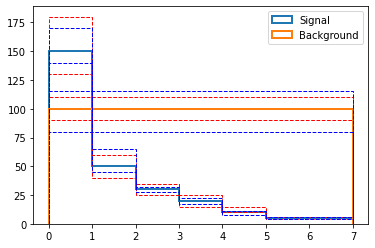

In [7]:
uncertainties = {
    "sig": {
        "up": jnp.vstack((
            [180., 60., 35., 25., 15., 6., 6.],   # up source 0 (red in the plot below)
            [170., 65., 32., 22., 11., 6., 6.])), # up source 1 (blue in the plot below)
        "down": jnp.vstack((
            [130., 40., 25., 15., 10., 4., 4.],   # down source 0
            [140., 45., 28., 17., 8., 4., 4.])),  # down source 1
    },
    "bkg": {
        "up": jnp.vstack((
            [110.]*7,  # up source 0
            [115]*7)), # up source 1
        "down": jnp.vstack((
            [90.]*7,   # down source 0
            [80]*7)),  # down source 1
    },
}

_,bins,_ = plt.hist(x[:-1], weights=sig_shape, bins=x, label="Signal", histtype="step", lw=2)
plt.hist(x[:-1], weights=bkg_shape, bins=bins, label="Background", histtype="step", lw=2)
colors = ["red", "blue"]
for i in range(2):
    for s in ["sig", "bkg"]:
        for d in ["up", "down"]:
            plt.hist(x[:-1], weights=uncertainties[s][d][i,:], bins=bins, ls="--", histtype="step", color=colors[i])
plt.legend()

As before, we register those shape uncertainties with the signal and the background process. Note that the nuisance parameter is now an array:

In [8]:
shape_nuis = Variable("shapes", [0.,0.], nuisance=True)
sig_contrib.add_shape_syst(shape_nuis, up=uncertainties["sig"]["up"], down=uncertainties["sig"]["down"])
bkg_contrib.add_shape_syst(shape_nuis, up=uncertainties["bkg"]["up"], down=uncertainties["bkg"]["down"])

Now we define a model and add the signal and background processes to it:

In [9]:
model = Model()
model.add_proc(sig)
model.add_proc(bkg)

Now we can "prepare" the model, and compile the NLL and gradient functions:

In [10]:
model.prepare()
model.compile()

Compiling pred
Compiling NLL
Compiling NLL grad
Tracing Hessian


## Running the fit

To go further we need to generate some pseudo-data. We can do that using frequentist toys, or using an "Asimov" toy.  For that we need to use the default values of the variables, but with a twist: we'll inject a signal strength of 0.05 instead of 1:

In [11]:
values = model.values_from_dict({mu: 0.05})
asimov = model.pred(values)

Let's fit those pseudo-data:

In [12]:
best_fit = model.fit(asimov)

Computing covariance matrix...


We can check out the best-fit value, the NLL at the minimum, and the (analytical!) covariance matrix:

In [13]:
print(f"Best fit: {best_fit.x}")
print(f"Minmum NLL: {best_fit.fun}")
print(f"Hessian at the minimum:\n{best_fit.hess_inv}")


Best fit: [ 5.00000068e-02 -3.25262830e-09 -9.68462346e-09 -7.50083739e-09]
Minmum NLL: 25.379123724585103
Hessian at the minimum:
[[ 0.00668827 -0.00310521 -0.00939339 -0.0073618 ]
 [-0.00310521  0.9506984  -0.10175006 -0.18456131]
 [-0.00939339 -0.10175006  0.78990573 -0.38105691]
 [-0.0073618  -0.18456131 -0.38105691  0.30866546]]


We can now obtain the profiled ("minos") 1-sigma bounds on mu, and compare them with the 1-sigma intervals from the covariance matrix. For that we need to use the "index" of the variable mu among the returned arrays:

In [14]:
mu_idx = mu.sub_idxs[0]
best_mu = best_fit.x[mu_idx]
print(f"Best 𝜇: {best_fit.x[mu_idx]:.2f} +- {jnp.sqrt(best_fit.hess_inv[mu_idx,mu_idx]):.2f}")
up,down,_,_ = model.minos_bounds(mu, best_fit, asimov)
print(f"Profiled best 𝜇: {best_mu:.2f} +{up-best_mu:.2f} -{best_mu-down:.2f}")

direction = np.zeros((len(best_fit.x,))) # using np for convenience because jax arrays are immutable
direction[mu_idx] = up-best_mu
up_stat = model.nll_crossings(direction, best_fit, asimov).x[mu_idx]
down_stat = model.nll_crossings(-direction, best_fit, asimov).x[mu_idx]
print(f"Stat.-only uncertainties on 𝜇: +{up_stat-best_mu:.2f} -{best_mu-down_stat:.2f}")

Best 𝜇: 0.05 +- 0.08
Profiled best 𝜇: 0.05 +0.09 -0.05
Stat.-only uncertainties on 𝜇: +0.07 -0.05


/home/swertz/Documents/Recherche/Stats/Tests/smoofit_venv/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Next, let's do a profile NLL plot and compare it with a simple NLL scan of $\mu$ (showing the effect of the nuisance parameters), and also superimpose the Minos bounds found just above:

In [15]:
x = np.linspace(0., 0.2, 50)
fixed = []
prof = []
for x_i in x:
    vals = np.copy(best_fit.x)
    vals[mu_idx] = x_i
    fixed.append(2 * (model.nll(vals, asimov) - best_fit.fun))
    prof.append(2 * (model.profile({mu: x_i}, best_fit, asimov).fun - best_fit.fun))

plt.plot(x, fixed, label="Fixed")
plt.plot(x, prof, label="Profiled")
plt.plot([x[0], x[-1]], [1.]*2, "--", color="black")
plt.plot([up, up], [0., 1.], "--", color="orange")
plt.plot([down, down], [0., 1.], "--", color="orange")
plt.plot([up_stat, up_stat], [0., 1.], "--", color="blue")
plt.plot([down_stat, down_stat], [0., 1.], "--", color="blue")
plt.gca().set_ylim([0.,1.5])
plt.gca().set_ylabel("$-2 (\log L  -  \log L_0)$")
plt.gca().set_xlabel("$\mu$")
plt.legend()

As you can see, the 1-sigma Minos bounds obtained above are correct! Furthermore, the lower bound on $\mu$ is properly taken into account.

## Pulls and impacts

Getting nuisance parameter pulls is easy:

In [16]:
pull_u_lum,pull_d_lum,_,_ = model.minos_bounds(lumi_nuis, best_fit, asimov)
lumi_idx = lumi_nuis.sub_idxs[0]
print(f"Lumi nuisance:    pull = {best_fit.x[lumi_idx]:4> .2f}, +{pull_u_lum:.2f} {pull_d_lum:.2f}")

pulls_u = []
pulls_d = []
for i in range(2):
    pull_u,pull_d,_,_ = model.minos_bounds(shape_nuis, best_fit, asimov, sub_idx=i)
    nuis_idx = shape_nuis.sub_idxs[i]
    print(f"Shape nuisance {i}: pull = {best_fit.x[nuis_idx]:4> .2f}, +{pull_u:.2f} {pull_d:.2f}")
    pulls_u.append(pull_u)
    pulls_d.append(pull_d)

Lumi nuisance:    pull = -0.00, +0.98 -0.97
Shape nuisance 0: pull = -0.00, +0.91 -0.85
Shape nuisance 1: pull = -0.00, +0.65 -0.49


And so are impacts (we use the up/down intervals from the pulls to calculate those):

In [17]:
impact_up = model.profile({lumi_nuis: pull_u_lum}, best_fit, asimov).x[mu_idx] - best_mu
impact_down = model.profile({lumi_nuis: pull_d_lum}, best_fit, asimov).x[mu_idx] - best_mu
print(f"Lumi nuisance:    impacts = {impact_up:.3f}, {impact_down:.3f}")

for i in range(2):
    impact_up = model.profile({shape_nuis: (pulls_u[i], i)}, best_fit, asimov).x[mu_idx] - best_mu
    impact_down = model.profile({shape_nuis: (pulls_d[i], i)}, best_fit, asimov).x[mu_idx] - best_mu
    print(f"Shape nuisance {i}: impacts = {impact_up:.3f}, {impact_down:.3f}")

/home/swertz/Documents/Recherche/Stats/Tests/smoofit_venv/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Lumi nuisance:    impacts = -0.003, 0.003
Shape nuisance 0: impacts = -0.010, 0.012
Shape nuisance 1: impacts = -0.014, 0.012
